### 서론 <br>

## 서울시, 작년 '따릉이' 이용 2,300만 건 돌파…코로나시대 교통수단 각광! <br>

2015년 10월부터 본격적인 서비스를 시작한 따릉이는 올해로 서비스 개시 6년차가 되었습니다. 꾸준한 성장세를 이어오던 따릉이는 작년 코로나19의 등장으로 3密 (밀페, 밀접, 밀집)을 피해 사람들의 새로운 교통수단으로 각광받으며 누적 가입자 수 278만 명을 돌파하며 서울시민 네 명 중 한 명이 사용한 공공자전거로 발돋움하였습니다. <br>

따릉이는 작년부터 QR코드를 도입하는 등 사용자에게 더 편리한 서비스를 제공하기 위해 많은 노력을 하였습니다. 현재까지 따릉이하면 제일 쉽게 떠오르는 것이 한강이고, 단거리 이동수단으로 사용하는 사람들도 있지만, 아직 써보지 못한 사람들 또한 많으며, 따릉이를 하나의 교통수단으로 인식하는지에 대해서는 의문점이 있습니다. 이렇게 최근 무서운 성장세로 발전 중인 따릉이지만, 더 많은 사람들이 따릉이를 단거리 이동수단으로 사용하고 하나의 교통수단으로 인식하여 시민들의 전반적인 교통 만족도가 높아졌으면 하는 바람으로 이 프로젝트를 시작하였습니다. <br>

공데이터를 통해 따릉이의 규모, 이용현황, 이용패턴 등을 분석하여 따릉이를 단거리 이동수단과 대중교통의 일환으로 자리잡을 수 있는 서비스와 정책을 제안하고자 합니다. 이 서비스를 통해 따릉이하면 한강뿐 아니라 “마트로 가는 이동수단”, “버스 및 지하철로 환승 가능한 이동수단”으로도 떠올리게 만들고 싶습니다!<br>

[출처] - [서울특별시](https://news.seoul.go.kr/traffic/archives/504919)

### 데이터 분석 <br>

* 이 주피터 노트북 파일에서는 분석 결과를 가독성있게 보여주기 위해서 코드를 부분적으로 bicycle_utils 파일에 옮겨두었습니다. (반복 사용 또는 데이터 전처리)
* bicycle_utils 코드 구현은 https://github.com/HYUNJS/Traffic_Dacon_2021 를 참조해주세요.

In [9]:
import sys, folium, pickle, matplotlib
if '../' not in sys.path:
    sys.path.append('../')
from bicycle_utils import *
from folium import plugins
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


In [10]:
## matplotlib 폰트 변경(한글 사용)
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin': 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows': 
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system')

사용한 데이터 리스트
1. 서울특별시 공공자전거 이용정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15248/F/1/datasetView.do

2. 서울특별시 공공자전거 신규가입자 정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15241/S/1/datasetView.do

3. 서울특별시 공공자전거 대여소 정보  
출처: http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do
        
4. 서울시 자전거도로 현황 통계  
출처: http://data.seoul.go.kr/dataList/276/S/2/datasetView.do

5. 서울특별시 공공자전거 대여이력 정보  
출처: http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

6. 서울교통공사 노선별 지하철역 정보  
출처: http://data.seoul.go.kr/dataList/OA-15442/S/1/datasetView.do

7. 서울특별시 공공자전거 대여소별 이용정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15249/F/1/datasetView.do


* 데이터의 배포가 통일하지 않아서 엑셀 & 파이썬을 이용해 전처리를 했습니다.  
* 전처리된 데이터 링크는 깃헙에 코드와 사용 방법과 함께 첨부하였습니다. (https://github.com/HYUNJS/Traffic_Dacon_2021)


In [11]:
save_flag = False # save visualized result

In [12]:
## load data file
new_user_age_df_raw = read_csv('../data/서울_공공자전거_대여_월별/연령별 신규사용자.csv')
bike_stations_june_raw = read_station_loc_csv('../data/서울_공공자전거_대여소')
station_loc_raw_df = read_station_loc_csv('../data/서울_공공자전거_대여소')
df2016 = read_csv('../data/서울_공공자전거_대여_이력/공공자전거 대여이력 정보_2016.tsv', sep='\t')
subway_loc = read_csv('../data/서울_지하철/위치정보.csv')
raw_data_for_bike_usage = read_csv('../data/서울_공공자전거_대여소별_이용정보/21.02_21.06.csv')
bike_road_raw = pd.read_csv('../data/자전거_도로/bike-road.txt', delimiter = "\t")

## filter corrupted rows of bicycle station location
corrupted_rows, station_loc_df = filter_corrupted_station_loc_table(station_loc_raw_df)

## Load bicycle transactions (2019~21년 대여이력) merged with location (preprocessed by python's multiprocessing - code and data shared in GitHub)
dfs_year_group_with_loc_filename = '../data/processed/dfs_year_group_with_loc.pkl'
with open(dfs_year_group_with_loc_filename, 'rb') as fp:
    dfs_year_group = pickle.load(fp)

## 월별 주말/평일/공휴일 수 
monthly_day_types_cnt_year_group_filename = '../data/processed/monthly_day_types_cnt_year_group.pkl'
with open(monthly_day_types_cnt_year_group_filename, 'rb') as fp:
    monthly_day_types_cnt_year_group = pickle.load(fp)
    
## dfs_year_group (2019~21년 대여이력) 을 월별 & 주말/평일/공휴일별 평균낸 데이터
monthly_mean_filename = '../data/processed/monthly_mean_df.pkl'
with open(monthly_mean_filename, 'rb') as fp:
    monthly_mean_df = pickle.load(fp)

../data/서울_공공자전거_대여_월별/연령별 신규사용자.csv 파일을 로딩합니다.
../data/서울_공공자전거_대여소\공공자전거 대여소 정보(21.06월 기준).csv 파일을 로딩합니다.
LCD 와 QR 거치대 모두 없는 대여소 개수: 0
자전거 대여소 위치 정보 데이터 전처리 완료
../data/서울_공공자전거_대여소\공공자전거 대여소 정보(21.06월 기준).csv 파일을 로딩합니다.
LCD 와 QR 거치대 모두 없는 대여소 개수: 0
자전거 대여소 위치 정보 데이터 전처리 완료
../data/서울_공공자전거_대여_이력/공공자전거 대여이력 정보_2016.tsv 파일을 로딩합니다.
../data/서울_지하철/위치정보.csv 파일을 로딩합니다.
../data/서울_공공자전거_대여소별_이용정보/21.02_21.06.csv 파일을 로딩합니다.
Drop corrupted data rows - #rows 1


## 1. 따릉이 사용량 및 가입자 트렌드 분석 (2017.01 ~ 2021.06)

### 1a) 따릉이 사용량 분석

* 2017년 1월 ~ 2021년 6월 월별 이용 증가량 그래프
* 월별 이용자 수 추이 그래프

사용한 데이터: 서울특별시 공공자전거 이용정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15248/F/1/datasetView.do#


In [13]:
YEARS = ['2017', '2018', '2019', '2020', '2021']
MONTHS = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
ENG_MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def count_total_monthly_volume():
    count_list, record_date_list = [], []
    for year in YEARS:
        path = '../data/서울_공공자전거_대여_월별/공공자전거 이용정보 ' + str(year) + '.tsv'
        df = read_csv(path, sep='\t')
        if "'대여일자'" in df.columns:
            df.rename(columns = {"'대여일자'": "대여일자"}, inplace = True)
        if "'이용건수'" in df.columns:
            df.rename(columns = {"'이용건수'": "이용건수"}, inplace = True)    
        print('Counting year {}'.format(year))

        ## 연도별 다른 포멧으로 공개된 데이터 파싱
        for i in range(len(MONTHS)):
            if year == '2021':
                if i > 5: ## 현재 2021년 6월까지 공개
                    break
                year_month = '{}-{}'.format(ENG_MONTHS[i], 21)
            elif year == '2020':
                year_month = '{}-{}'.format(year, MONTHS[i])
            elif year == '2019':
                year_month = '{}-{}'.format(ENG_MONTHS[i], 19)
            elif year == '2018':
                year_month = '{}-{}'.format(ENG_MONTHS[i], 18)
            elif year == '2017':
                year_month =  '\'{}{}\''.format(2017, MONTHS[i])    
            count_list.append(df[df['대여일자'] == year_month]['이용건수'].sum())
            record_date_list.append(year + "-" + MONTHS[i])
    return count_list, record_date_list

def tabularize_total_monthly_volume(count_by_ten_hundreds_list, record_date_list):
    df = pd.DataFrame({'년-월': record_date_list, '이용자수(만명)': count_by_ten_hundreds_list})
    df['year'] = df['년-월'].apply(lambda x: x.split('-')[0])
    df['month'] = df['년-월'].apply(lambda x: x.split('-')[1])
    return df


count_list, record_date_list = count_total_monthly_volume()
count_by_ten_hundreds_list = [c / 1e4 for c in count_list] ## 가독성을 위해 만 단위로 나눔
total_monthly_volume_df = tabularize_total_monthly_volume(count_by_ten_hundreds_list, record_date_list)

../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2017.tsv 파일을 로딩합니다.
Counting year 2017
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2018.tsv 파일을 로딩합니다.
Counting year 2018
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2019.tsv 파일을 로딩합니다.
Counting year 2019
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2020.tsv 파일을 로딩합니다.
Counting year 2020
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2021.tsv 파일을 로딩합니다.
Counting year 2021


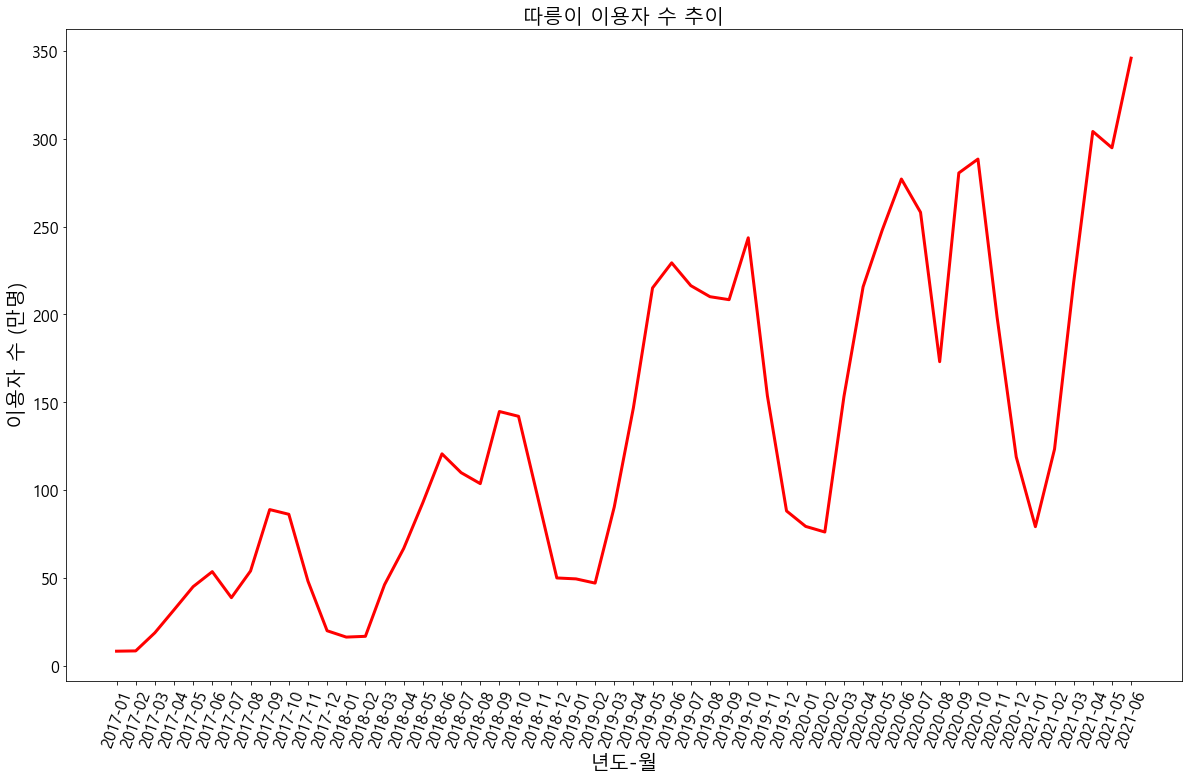

In [14]:
plt.figure(figsize=(20, 12), facecolor='white')
plt.xlabel('년도-월', fontsize=20)
plt.ylabel('이용자 수 (만명)', fontsize=20)
plt.xticks(fontsize = 16, rotation = 70)
plt.yticks(fontsize = 16)
plt.title('따릉이 이용자 수 추이', fontsize=20)
plt.plot(record_date_list, count_by_ten_hundreds_list, color = 'red', linewidth = 3)
if save_flag:
    plt.savefig('1.따릉이-이용자-수-추이.png')
plt.show()

### [그래프 해석] 전체 이용자 수 
- 2017 이후 따릉이 이용자 수 꾸준히 상승하는 추세임 <br>
- 날씨영향으로 여름과 겨울에는 이용자 수가 감소함 <br>

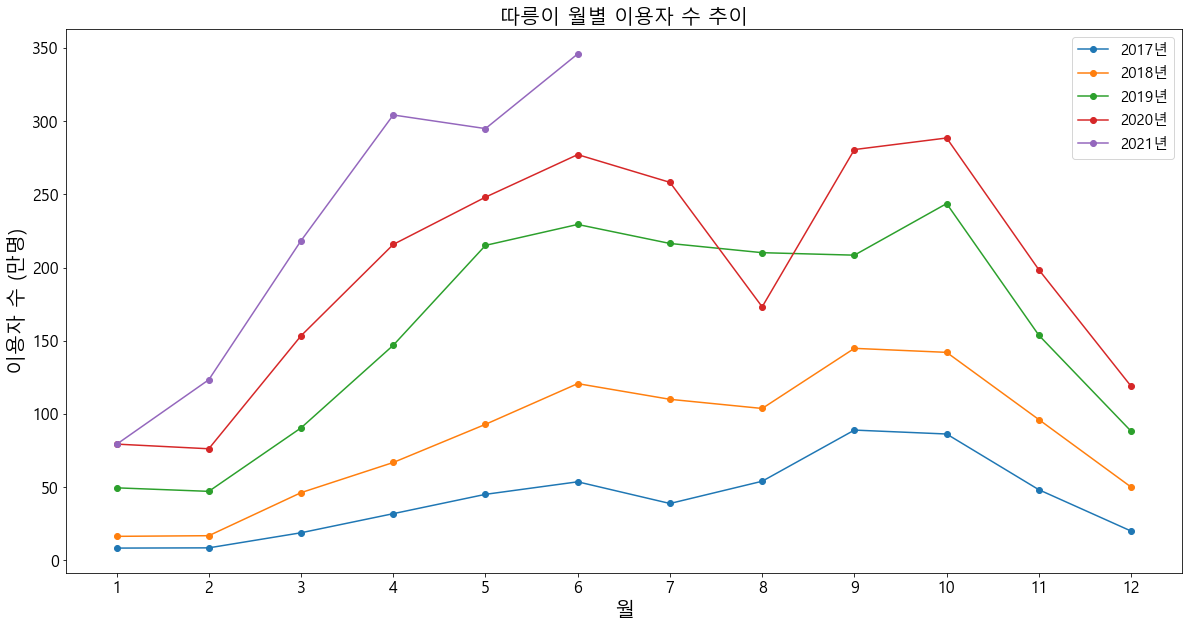

In [15]:
plt.figure(figsize=(20, 10), facecolor='white')
plt.xlabel('월', fontsize = 20)
plt.ylabel('이용자 수 (만명)', fontsize = 20)
plt.xticks(list(range(1, len(MONTHS)+1)), fontsize = 16)
plt.yticks(fontsize = 16)
# plt.ticklabel_format(style = 'sci', scilimits = (4, 4))
plt.title('따릉이 월별 이용자 수 추이', fontsize = 20)
for year in YEARS:
    tgt_rows = total_monthly_volume_df[total_monthly_volume_df['year'] == year]
    plt.plot(tgt_rows['month'].astype(int), tgt_rows['이용자수(만명)'], label='{}년'.format(year), marker='o')
plt.legend(prop={'size': 15})
if save_flag:
    plt.savefig('1.따릉이dd-월별-이용자-수-추이.png')
plt.show()

### [그래프 해석] 월별 이용자 수 
- 날씨가 좋은 봄과 가을에 이용자 수 증가함 <br>
- 전체 이용자 수 증가에 따라 여름에는 이용자 수 증가하였으나, 상대적으로 겨울에는 크게 증가하지 못함 <br>

### 1b) 따릉이 신규 가입자 트렌드 분석 (2017.01 ~ 2021.06)

* 신규 가입자 추이 및 누적 트렌드 분석
* 연령대별 신규 가입자 트렌드 분석
* 2018년과 2020년 연령대별 신규 가입자 비율의 변화 분석 (2018.06 ~ 2019.05 vs 2020.06 ~ 2021.05)

사용한 데이터: 서울특별시 공공자전거 신규가입자 정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15241/S/1/datasetView.do

In [16]:
new_user_age_df = new_user_age_df_raw.fillna(0)
new_user_age_df['datetime'] = new_user_age_df['날짜'].apply(lambda x: datetime.strptime(x, '%y-%b'))
new_user_age_df['year'] = new_user_age_df['datetime'].apply(lambda x: x.year)
new_user_age_df['month'] = new_user_age_df['datetime'].apply(lambda x: x.month)
new_user_age_df

,날짜,10대,20대,30대,40대,50대,60대,70대,기타,datetime,year,month
0,17-Jan,204,1716,760,472,180,46,14,0.0,2017-01-01,2017,1
1,17-Feb,365,2741,1137,616,220,41,28,0.0,2017-02-01,2017,2
2,17-Mar,727,9523,3871,2135,702,163,498,0.0,2017-03-01,2017,3
3,17-Apr,1409,20809,8473,3761,1219,256,94,0.0,2017-04-01,2017,4
4,17-May,2321,27635,11563,5425,1986,445,197,0.0,2017-05-01,2017,5
5,17-Jun,2148,26789,12866,6532,2417,516,185,0.0,2017-06-01,2017,6
6,17-Jul,1330,13761,6086,3472,1616,347,109,0.0,2017-07-01,2017,7
7,17-Aug,1866,20289,8361,4482,1881,425,137,0.0,2017-08-01,2017,8
8,17-Sep,3122,40093,16072,7673,2985,632,227,0.0,2017-09-01,2017,9
9,17-Oct,3130,32100,15500,9021,3454,710,267,0.0,2017-10-01,2017,10


In [17]:
## 전체 연령 (기타 포함) 신규 및 누적 가입자 계산
tgt_ages = ['10대', '20대', '30대', '40대', '50대', '60대', '70대', '기타']
new_user_by_month_cumsum = new_user_age_df[tgt_ages].cumsum().sum(axis=1)
new_user_by_month = new_user_age_df[tgt_ages].sum(axis=1)
datetime_str = new_user_age_df['datetime'].apply(lambda x: x.strftime('%Y-%m'))

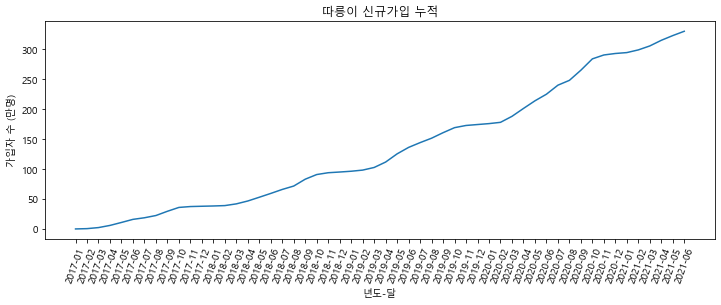

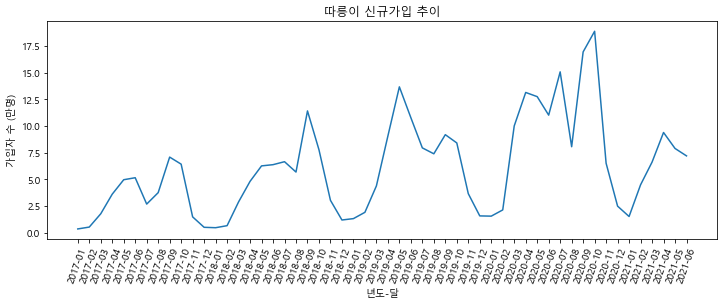

In [18]:
## 신규 가입자 누적
plt.figure(figsize=(12, 4))
plt.plot(datetime_str, new_user_by_month_cumsum / 1e4)
plt.title("따릉이 신규가입 누적")
plt.xticks(rotation=70)
plt.xlabel("년도-달")
plt.ylabel("가입자 수 (만명)")
if save_flag:
    plt.savefig("1.따릉이 신규가입 누적.png")
plt.show()

## 신규 가입자 추이
plt.figure(figsize=(12,4))
plt.plot(datetime_str, new_user_by_month / 1e4)
plt.title("따릉이 신규가입 추이")
plt.xticks(rotation=70)
plt.xlabel("년도-달")
plt.ylabel("가입자 수 (만명)")
if save_flag:
    plt.savefig("1.따릉이 신규가입 추이.png")
plt.show()

### [그래프 해석] 신규 가입자 수 
- 신규가입자 꾸준히 상승하는 중 <br>
- 코로나 영향으로 인해 2020년 성장세가 이전보다 더 가파름  <br>

In [19]:
## 연령대별 가입자 누적 계산
tgt_ages = ['10대', '20대', '30대', '40대', '50대', '60대', '70대']
datetime_str = new_user_age_df['datetime'].apply(lambda x: x.strftime('%Y-%m'))
df_cumsum_age = new_user_age_df[tgt_ages].cumsum()

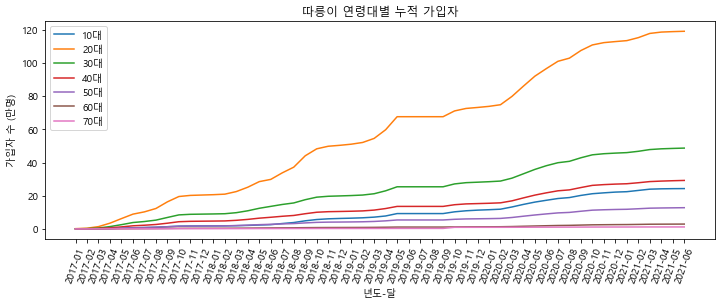

In [20]:
plt.figure(figsize=(12,4))
for tgt_age in tgt_ages:
    ys = df_cumsum_age[tgt_age].values / 1e4
    plt.plot(datetime_str, ys, label=tgt_age)
plt.title("따릉이 연령대별 누적 가입자")
plt.xticks(rotation=70)
plt.xlabel("년도-달")
plt.ylabel("가입자 수 (만명)")
plt.legend()
if save_flag:
    plt.savefig("1.따릉이 연령대별 누적 가입자.png")
plt.show()

### [그래프 해석] 연령대별 누적 가입자 
- 성장하는 속도는 다르지만 누적 가입자 순위는 매년 다음을 유지함: 20대> 30대>40대>10대> 50대> 60대> 70대

In [21]:
## 2018년과 2020년 연령대별 가입자수 비율 계산
tgt_ages = ['10대', '20대', '30대', '40대', '50대', '60대', '70대']
datetime_2018_06, datetime_2019_05 = datetime(2018, 6, 1), datetime(2019, 5, 1)
datetime_2020_06, datetime_2021_05 = datetime(2020, 6, 1), datetime(2021, 5, 1)
mask_2018_19 = (new_user_age_df['datetime'] >= datetime_2018_06) & (new_user_age_df['datetime'] <= datetime_2019_05)
mask_2020_21 = (new_user_age_df['datetime'] >= datetime_2020_06) & (new_user_age_df['datetime'] <= datetime_2021_05)
new_user_age_18_19_df = new_user_age_df.loc[mask_2018_19, tgt_ages]
new_user_age_20_21_df = new_user_age_df.loc[mask_2020_21, tgt_ages]
new_user_age_18_19_dict = dict(new_user_age_18_19_df.sum())
new_user_age_20_21_dict = dict(new_user_age_20_21_df.sum())

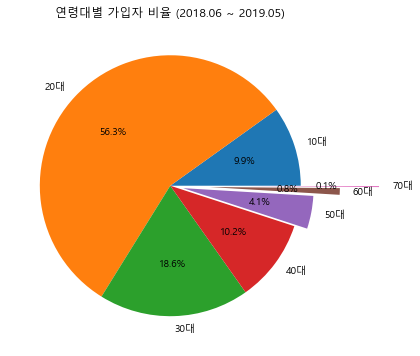

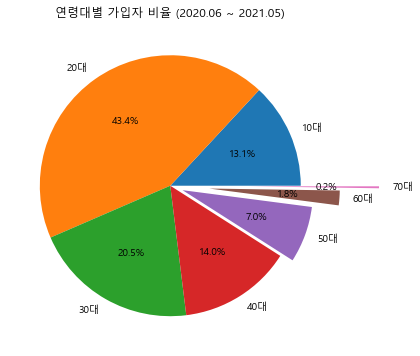

In [60]:
explode = (0, 0, 0, 0, 0.1, 0.3, 0.6)

plt.figure(figsize=(6, 6))
plt.pie(new_user_age_18_19_dict.values(), labels=new_user_age_18_19_dict.keys(), autopct='%0.1f%%', explode=explode)
plt.title('연령대별 가입자 비율 (2018.06 ~ 2019.05)')
if save_flag:
    plt.savefig("1.연령대별 가입자 비율 (2018.06 ~ 2019.05).png")
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(new_user_age_20_21_dict.values(), labels=new_user_age_20_21_dict.keys(), autopct='%0.1f%%', explode=explode)
plt.title('연령대별 가입자 비율 (2020.06 ~ 2021.05)')
if save_flag:
    plt.savefig("1.연령대별 가입자 비율 (2020.06 ~ 2021.05).png")
plt.show()

### [그래프 해석] 연령대별 신규 가입자 비율
•	따릉이의 가장 큰 사용자인 2030 세대의 비중이 2016년 74.9%에서 2019년 63.9%로 감소함 <br> 
•	2019년 4050세대의 가입비중이 2016년대비 1.5배 증가함 (2016년: 14.2%, 2019년: 21.1%) <br>
•	20대에 과도하게 치중되어 있던 가입자 수가 시간이 지남에 따라 비교적 고루 분포되는 추세임 


## 2. 서울시 자전거 이용 인프라 현황 분석 (2021년 6월)

### 2a) 따릉이 대여소 현황

* LCD vs QR 거치대 지도 시각화
* 자치구별 대여소 개수 지도 시각화

사용한 데이터: 서울특별시 공공자전거 대여소 정보  
출처: http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do

In [23]:
bike_stations_june = bike_stations_june_raw.copy()
bike_stations_june

,대여소 번호,보관소(대여소)명,소재지(자치구),상세주소,위도,경도,설치 시기,운영 방식,거치대수
0,102,망원역 1번출구 앞,마포구,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06,LCD,20
1,103,망원역 2번출구 앞,마포구,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06,LCD,14
2,104,합정역 1번출구 앞,마포구,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06,LCD,13
3,105,합정역 5번출구 앞,마포구,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06,LCD,5
4,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,37.548645,126.912826,2015-09-06,LCD,10
...,...,...,...,...,...,...,...,...,...
2462,4864,송파사거리,송파구,송파구 송파동 97-2,37.502056,127.110550,2021-04-27,QR,6
2463,4865,한성백제역 1번출구 뒤,송파구,송파구 방이동 45-4,37.516342,127.115593,2021-04-28,QR,5
2464,4867,가락대림아파트 앞,송파구,송파구 가락동 94-9,37.500027,127.118431,2021-04-28,QR,10
2465,4868,레이크 호텔 앞,송파구,송파구 석촌동 158,37.507172,127.101242,2021-05-18,QR,7


In [24]:
## LCD vs QR 대여소 지도 시각화
color_list = ['#e3cf0e', '#00a324']
bike_holder_map = folium.Map(location = [37.554648, 126.972559], zoom_start = 11, tiles = 'CartoDB positron')
for idx in bike_stations_june.index:
    lat = float(bike_stations_june.loc[idx, '위도'])
    lng = float(bike_stations_june.loc[idx, '경도'])
    r = float(bike_stations_june.loc[idx, '거치대수'])
    fillColor = color_list[0] if bike_stations_june.loc[idx, '운영 방식'] == 'LCD' else color_list[1]
    folium.CircleMarker([lat, lng], color = fillColor, fill_color = fillColor, radius = r/3, fill_opacity = 0.8, weight = 1).add_to(bike_holder_map)        

In [25]:
if save_flag:
    bike_holder_map.save('2.2021년-6월-자치구별-거치대수-bubble.html')
bike_holder_map

### [지도 해석] 따릉이 대여소 현황
•	QR대여소와 LCD 대여소 고르게 분포되어 있음 

In [26]:
## 자치구별 대여소 개수
bike_stations_june_group_by_zone = bike_stations_june.groupby('소재지(자치구)').agg({'대여소 번호': 'count'})
bike_stations_june_group_by_zone['자치구'] = bike_stations_june_group_by_zone.index
bike_stations_june_group_by_zone.head(5)

,대여소 번호,자치구
소재지(자치구),,
강남구,145,강남구
강동구,111,강동구
강북구,60,강북구
강서구,162,강서구
관악구,71,관악구


In [27]:
## 자치구별 대여소 지도 시각화
state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
bike_holder_map_2 = folium.Map(location=[37.562225, 126.978555], tiles="OpenStreetMap", zoom_start=11)
folium.Choropleth(
    geo_data=state_geo,
    name='자치구 별 대여소 수',
    data=bike_stations_june_group_by_zone,
    columns=('자치구', '대여소 번호'),
    key_on='feature.properties.name',
    fill_color='Greens',
    fill_opacity = 1,
    line_opacity = 1,
    color = 'black',
    legend_name = '대여소 수'
).add_to(bike_holder_map_2)
label_seoul_zones(bike_holder_map_2)


In [28]:
if save_flag:
    bike_holder_map_2.save('2.2021년-6월-자치구별-거치대수.html')
bike_holder_map_2

### [지도 해석] 따릉이 대여소 현황
•	강서구와 송파구에 대여소가 가장 밀집되어있음  <br>
•	도봉구, 강복구, 성북구, 중랑구, 동작구,관악구 그리고 금천구가 다른 지역대비 밀집도가 낮음



## 3. 따릉이 이용자의 행동 패턴 분석

### 3a) 따릉이 이용 루트 분석 (2020년 1월)

* 따릉이 이용 구간별 월 사용량
* 따릉이 이용 루트 지도 시각화

사용한 데이터: 서울특별시 공공자전거 대여이력 정보  
출처: http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

서울특별시 공공자전거 대여소 정보  
출처: http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do

In [29]:
station_id_table = station_loc_df[['대여소 번호']].reset_index()
src_transaction = dfs_year_group['2020'][0]['대여 대여소번호'].reset_index().rename(columns={'index':'tid'})
tgt_transaction = dfs_year_group['2020'][0]['반납대여소번호'].reset_index().rename(columns={'index':'tid'})
src_station_id = station_id_table.rename(columns= {'대여소 번호': '대여 대여소번호'})
tgt_station_id = station_id_table.rename(columns= {'대여소 번호': '반납대여소번호'})
src_transaction_w_idx = pd.merge(src_transaction, src_station_id, on='대여 대여소번호', how='left').rename(columns={'index': 'start_idx'})
tgt_transaction_w_idx = pd.merge(tgt_transaction, tgt_station_id, on='반납대여소번호', how='left').rename(columns={'index':'end_idx'})
transaction_w_idx = pd.merge(src_transaction_w_idx, tgt_transaction_w_idx, on='tid', how='left')
transaction_w_idx

,tid,대여 대여소번호,start_idx,반납대여소번호,end_idx
0,0,429,285,372,236
1,1,429,285,372,236
2,2,429,285,372,236
3,3,429,285,372,236
4,4,429,285,372,236
...,...,...,...,...,...
739812,739812,1646,1180,1680,1209
739813,739813,1646,1180,1680,1209
739814,739814,1646,1180,1680,1209
739815,739815,1646,1180,1680,1209


In [30]:
## rename columns for differentiating src and tgt
src_station_name_df = station_loc_df[['보관소(대여소)명']].reset_index().rename(columns={'index':'start_idx', '보관소(대여소)명':'대여소'})
tgt_station_name_df = station_loc_df[['보관소(대여소)명']].reset_index().rename(columns={'index':'end_idx', '보관소(대여소)명':'반납소'})
num_stations = len(station_id_table)
bicycle_matrix = np.zeros([num_stations, num_stations])
count_matrix_df = transaction_w_idx.groupby(['start_idx', 'end_idx']).size().reset_index().rename(columns={0:'count'})
count_matrix_w_name_df = pd.merge(count_matrix_df, src_station_name_df, on='start_idx', how='left')
count_matrix_w_name_df = pd.merge(count_matrix_w_name_df, tgt_station_name_df, on='end_idx', how='left')
count_matrix_w_name_df[['대여소', '반납소', 'count']].sort_values('count', ascending=False).head(10)

,대여소,반납소,count
8711,여의나루역 1번출구 앞,여의나루역 1번출구 앞,438
32959,자양나들목,뚝섬유원지역 1번출구 앞,430
6935,하늘채코오롱아파트 건너편,홍대입구역 2번출구 앞,403
94453,봉림교 교통섬,동방1교,387
34644,성수역 2번출구 앞,성동세무서 건너편,361
36825,자양중앙나들목,뚝섬유원지역 1번출구 앞,354
97661,동방1교,봉림교 교통섬,352
40467,장안동위더스빌옆,장한평역 1번출구 (국민은행앞),323
36503,성수역3번출구,이마트 버스정류소 옆,318
91830,장승배기역 5번출구,노량진역 5번출구,309


In [83]:
bicycle_matrix[count_matrix_df['start_idx'], count_matrix_df['end_idx']] = count_matrix_df['count']
print(bicycle_matrix.shape)
bicycle_matrix

(2466, 2466)


array([[110.,  12.,  23., ...,   0.,   0.,   0.],
       [ 15.,  50.,  21., ...,   0.,   0.,   0.],
       [ 49.,  32.,  35., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [32]:
mask0 = bicycle_matrix == 0
maskA = (bicycle_matrix > 0) & (bicycle_matrix < 5)
maskB = (bicycle_matrix >= 5) & (bicycle_matrix < 10)
maskC = (bicycle_matrix >= 10) & (bicycle_matrix < 50)
maskD = (bicycle_matrix >= 50) & (bicycle_matrix < 100)
maskE = (bicycle_matrix >= 100)
labels = ['1~5', '5~10', '10~50', '50~100','100~']
colors = ['lightgrey', 'silver', 'grey', 'black', 'red']
counts = [m.sum() for m in [maskA, maskB, maskC, maskD, maskE]]
bicycle_matrix_label = np.empty_like(bicycle_matrix, dtype='<U10')
bicycle_matrix_label[mask0] = 'white'
bicycle_matrix_label[maskA] = colors[0]
bicycle_matrix_label[maskB] = colors[1]
bicycle_matrix_label[maskC] = colors[2]
bicycle_matrix_label[maskD] = colors[3]
bicycle_matrix_label[maskE] = colors[4]

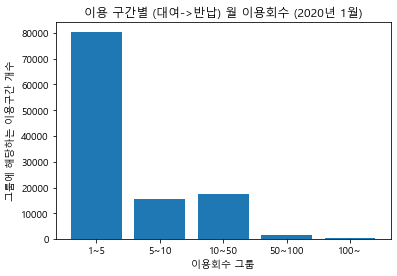

In [33]:
## 따릉이 이용 구간별 월 사용량
counts = [maskA.sum(), maskB.sum(), maskC.sum(), maskD.sum(), maskE.sum()]
plt.bar(labels, counts)
plt.xlabel("이용회수 그룹")
plt.ylabel("그룹에 해당하는 이용구간 개수")
plt.title('이용 구간별 (대여->반납) 월 이용회수 (2020년 1월)')
if save_flag:
    plt.savefig('3.이용구간별 (대여-반납) 월 이용회수 (2020년 1월).png')
plt.show()

In [85]:
tgt_mask_list = [maskA, maskB, maskC, maskD, maskE]
node_pos = np.array([station_loc_df['위도'], station_loc_df['경도']]).T

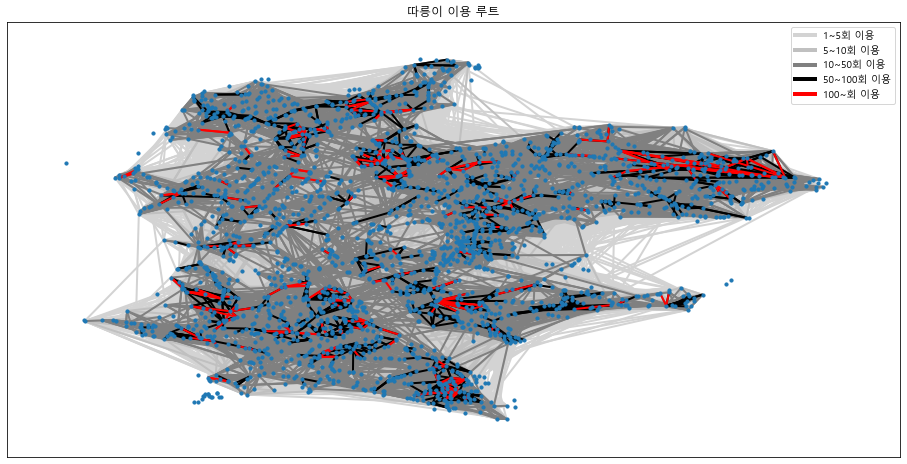

In [107]:
# ## 따릉이 이용 루트 시각화
plt.figure(figsize=(16, 8), frameon=False)
g = nx.Graph()
g.add_nodes_from(list(range(bicycle_matrix.shape[0])))
_ = nx.draw_networkx_nodes(g, node_pos, node_size=10)

for idx, tgt_mask in enumerate(tgt_mask_list):
    edgelist = np.array(np.nonzero(tgt_mask)).T
    _ = nx.draw_networkx_edges(g, pos=node_pos, edgelist=edgelist, width=2, edge_color=colors[idx])

legend_elements = [
    Line2D([0], [0], color='lightgrey', lw=4, label='1~5회 이용'),
    Line2D([0], [0], color='silver', lw=4, label='5~10회 이용'),
    Line2D([0], [0], color='grey', lw=4, label='10~50회 이용'),
    Line2D([0], [0], color='black', lw=4, label='50~100회 이용'),
    Line2D([0], [0], color='red', lw=4, label='100~회 이용')
]
plt.legend(handles=legend_elements)
plt.title("따릉이 이용 루트")
plt.show()
# plt.close()

In [106]:
## 따릉이 이용 루트 지도 시각화
## 10회 미만 이용구간들은 가독성을 위해서 생략함
edge_colors = ['lightgrey', 'grey', 'black']
node_color = 'blue'

## initial location of seoul
seoul_lon, seoul_lat = (127.0, 37.55)
bicycle_trace_map = folium.Map(
    location=(seoul_lat, seoul_lon),
    zoom_start=11,
    tiles='OpenStreetMap',
#     tiles='Cartodb Positron',
)

## marker
mark_cluster_group = folium.plugins.MarkerCluster(control=False)
bicycle_trace_map.add_child(mark_cluster_group)
g1 = folium.plugins.FeatureGroupSubGroup(mark_cluster_group, '10~50 회 이용구간 (연회색)')
bicycle_trace_map.add_child(g1)
g2 = folium.plugins.FeatureGroupSubGroup(mark_cluster_group, '50~100 회 이용구간 (진회색)')
bicycle_trace_map.add_child(g2)
g3 = folium.plugins.FeatureGroupSubGroup(mark_cluster_group, '100~ 회 이용구간 (검은색)')
bicycle_trace_map.add_child(g3)

## draw stations as node - 가독성을 위해 노드는 생략했습니다.
# for i in range(len(node_pos)):
#     folium.CircleMarker(
#         location=tuple(node_pos[i]),
#         radius=1,
#         color=node_color,
#     ).add_to(bicycle_trace_map)
# print("Draw Nodes")

## draw route as edge
idx_offset = 2
marker_group = [g1, g2, g3]
for idx, tgt_mask in enumerate(tgt_mask_list[idx_offset:]):
    edgelist = np.array(np.nonzero(tgt_mask)).T
    src2dst_loc = node_pos[edgelist, :]
    weight = 0.5 * (idx+1)
    fillOpacity = 0.3 * (idx+1)
    for tgt_edge in node_pos[edgelist, :]:
        folium.PolyLine(locations=tgt_edge, weight=weight, fillOpacity=fillOpacity, color=edge_colors[idx]).add_to(marker_group[idx])
    print("Draw Edge of group {}".format(idx))
folium.LayerControl(collapsed=False).add_to(bicycle_trace_map)

Draw Edge of group 0
Draw Edge of group 1
Draw Edge of group 2


In [79]:
if save_flag:
    bicycle_trace_map.save('3.자전거 이용 루트 지도 with 인근 지역 정보(10회 이상 이용구간).html')
# bicycle_trace_map

제한된 용량으로 인해 사진으로 보여드리겠습니다. interactive 한 지도는 [링크](https://github.com/HYUNJS/Traffic_Dacon_2021/blob/main/notebook/%EC%9E%90%EC%A0%84%EA%B1%B0%20%EC%9D%B4%EC%9A%A9%20%EB%A3%A8%ED%8A%B8%20%EC%A7%80%EB%8F%84%20with%20%EC%9D%B8%EA%B7%BC%20%EC%A7%80%EC%97%AD%20%EC%A0%95%EB%B3%B4(10%ED%9A%8C%20%EC%9D%B4%EC%83%81%20%EC%9D%B4%EC%9A%A9%EA%B5%AC%EA%B0%84).html)로 대체합니다. 파일을 다운로드 받아서 봐주시면 감사하겠습니다.

항선 - 우리 피피티에 넣은 지도 사진을 여기 이미지로 넣어줘.

### [지도 해석] 따릉이 이동 특성
•	따릉이는 주로 근거리 교통수단으로 사용되며 1~5회 이용되는 구간이 가장 많은 비중을 차지함 <br>
•	따릉이의 이용패턴은 “소규모 그룹”으로 나누어질 수 있음 <br>
    &nbsp;&nbsp; •	소규모 그룹내부는 강하게 연결된 패턴을 보임 <br>
 &nbsp;&nbsp;  •	각 그룹끼리는 상대적으로 약하게 연결된 패턴을 보임 <br>
•	자주 이용되는 구간도 주로 밀집되어 있는 모습을 보임 <br>
•	같은 구간보다 새로운 구간으로 따릉이를 더 많이 사용함을 알 수 있음 


## 4. 따릉이 이용 목적 분석 (2016년과 2019년의 비교)

사용한 데이터: 서울특별시 공공자전거 대여이력 정보  
출처: http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

In [37]:
## find station id wrongly formated rows
start_id_is_digit = np.array(list(map(lambda sid: sid.isdigit(), df2016['대여소번호'])))
end_id_is_digit = np.array(list(map(lambda sid: sid.isdigit(), df2016['반납대여소번호'])))
tgt_row_mask = np.logical_and(start_id_is_digit, end_id_is_digit)

## process pairwise distance
df2016_raw = df2016[tgt_row_mask].rename(columns={'대여소번호': '대여 대여소번호'})
df2016_raw['대여 대여소번호'] = df2016_raw['대여 대여소번호'].astype(int)
df2016_raw['반납대여소번호'] = df2016_raw['반납대여소번호'].astype(int)
df2016_loc = process_pairwise_distance(df2016_raw, station_loc_df)

매칭된 대여소 위치 정보가 없어서 삭제된 대여 기록량: 135658
Process pairwise distance takes 4.9 sec


### 4a) 반납 위치와 대여 위치 비교

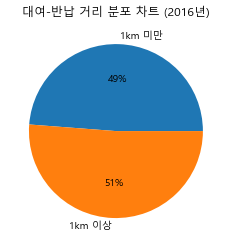

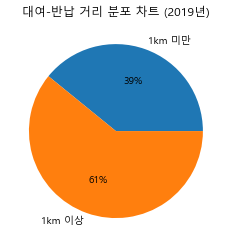

In [38]:
same_cnt_2016 = (df2016_loc['대여소 거리'] < 1000).sum()
diff_cnt_2016 = len(df2016_loc) - same_cnt_2016
plt.pie([same_cnt_2016, diff_cnt_2016], labels=['1km 미만', '1km 이상'], autopct='%1.0f%%')
plt.title("대여-반납 거리 분포 차트 (2016년)")
if save_flag:
    plt.savefig('4.대여-반납 거리 분포 차트 (2016년).png')
plt.show()

df2019_dist = pd.concat([dfs_year_group['2019'][i]['대여소 거리'] for i in range(len(dfs_year_group['2019']))])
same_cnt_2019 = (df2019_dist < 1000).sum()
diff_cnt_2019 = len(df2019_dist) - same_cnt_2019
plt.pie([same_cnt_2019, diff_cnt_2019], labels=['1km 미만', '1km 이상'], autopct='%1.0f%%')
plt.title("대여-반납 거리 분포 차트 (2019년)")
if save_flag:
    plt.savefig('4.대여-반납 거리 분포 차트 (2019년).png')
plt.show()

### [그래프 해석] 따릉이 이용 목적
•	대여 반납 거리가 1km 미만일 때는 ‘여가,운동’ 목적으로 따릉이를 사용, 1km 이상일때는 이동수단으로 따릉이를 사용한다고 가정  <br>
•	대여-반납 거리가 1km 이상인 비율이 51%(2016년)에서 61%(2019)로 늘어남 <br>
•	2016년대비 2019년에는 이동수단으로 따릉이를 사용하는 비율이 늘어났다고 볼 수 있음 


### 4b) 반납/대여 위치와 인근 지하철 유무 (거리가 200m 이내에 있는가) 

사용한 데이터: 서울특별시 공공자전거 대여이력 정보  
출처: http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do

사용한 데이터: 서울교통공사 노선별 지하철역 정보  
출처: http://data.seoul.go.kr/dataList/OA-15442/S/1/datasetView.do

In [39]:
subway_loc_tgt = subway_loc[['역위도', '역경도']]
loc_cols = ['대여 대여소 위도', '대여 대여소 경도', '반납 대여소 위도', '반납 대여소 경도']
df2016_loc_tgt = df2016_loc[loc_cols]
df2019_loc_tgt = pd.concat([dfs_year_group['2019'][i][loc_cols] for i in range(len(dfs_year_group['2019']))])

In [40]:
## 2016/19년 대여/반납 위치와 인근 지하철 거리 계산 후 200m 이내에 지하철 유무 확인 
bicycle2subway_dist_start_total_2016_200, bicycle2subway_dist_end_total_2016_200 = bicycle2subway_dist(df2016_loc_tgt, subway_loc_tgt, thresh=200)
bicycle2subway_dist_start_total_2019_200, bicycle2subway_dist_end_total_2019_200 = bicycle2subway_dist(df2019_loc_tgt, subway_loc_tgt, thresh=200)


[1/1] 대여소-지하철 처리 33.7 초
[1/1] 반납소-지하철 처리 14.3 초
[1/12] 대여소-지하철 처리 19.8 초
[1/12] 반납소-지하철 처리 18.1 초
[2/12] 대여소-지하철 처리 16.5 초
[2/12] 반납소-지하철 처리 16.8 초
[3/12] 대여소-지하철 처리 19.7 초
[3/12] 반납소-지하철 처리 16.3 초
[4/12] 대여소-지하철 처리 16.7 초
[4/12] 반납소-지하철 처리 17.3 초
[5/12] 대여소-지하철 처리 18.0 초
[5/12] 반납소-지하철 처리 16.3 초
[6/12] 대여소-지하철 처리 22.6 초
[6/12] 반납소-지하철 처리 15.0 초
[7/12] 대여소-지하철 처리 16.8 초
[7/12] 반납소-지하철 처리 15.6 초
[8/12] 대여소-지하철 처리 16.8 초
[8/12] 반납소-지하철 처리 15.5 초
[9/12] 대여소-지하철 처리 16.7 초
[9/12] 반납소-지하철 처리 14.0 초
[10/12] 대여소-지하철 처리 15.6 초
[10/12] 반납소-지하철 처리 13.9 초
[11/12] 대여소-지하철 처리 16.0 초
[11/12] 반납소-지하철 처리 15.1 초
[12/12] 대여소-지하철 처리 16.7 초
[12/12] 반납소-지하철 처리 19.6 초


In [41]:
total2016_200, end2016_200, start2016_200 = len(bicycle2subway_dist_end_total_2016_200), bicycle2subway_dist_start_total_2016_200.sum(), bicycle2subway_dist_end_total_2016_200.sum()
total2019_200, end2019_200, start2019_200 = len(bicycle2subway_dist_start_total_2019_200), bicycle2subway_dist_start_total_2019_200.sum(), bicycle2subway_dist_end_total_2019_200.sum()


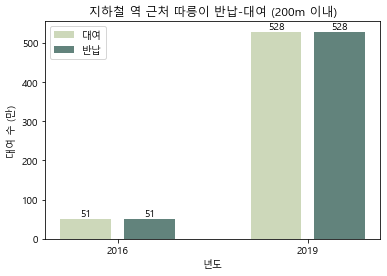

In [42]:
fig, ax = plt.subplots() 
rects1 = ax.bar([0, 3], [int(start2016_200/1e4), int(start2019_200/1e4)],label='대여', color='#CDD8BA')
rects2 = ax.bar([1, 4], [int(end2016_200/1e4), int(end2019_200/1e4)],label='반납', color='#62837C')
plt.xlabel('년도')
plt.ylabel('대여 수 (만)')
plt.xticks([0.5, 3.5], ['2016', '2019'])
plt.legend()
ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
plt.title("지하철 역 근처 따릉이 반납-대여 (200m 이내)")
if save_flag:
    plt.savefig('4.지하철 역 근처 따릉이 반납-대여 (200m 이내).png')
plt.show()

### [그래프 해석] 따릉이 이용 목적
•	지하철 역 근처 (200m) 이내에서 사용된 따릉이는 지하철 사용 후 혹은 지하철을 사용하기 위한 목적으로 봄 <br>
•	지하철 역 근처에서 사용된 따릉이 수가 10배 이상 증가함 <br>
•	지하철과 연계하여 환승목적으로 사용되는 따릉이의 수가 증가하고 있다고 추정가능 <br>


### 4c) 시간별 일평균 대여/반납량 (2019년)

In [43]:
## 2019 년만 평균
hourly_grouped_monthly_df_return = group_by_hourly_usage_all({'2019': dfs_year_group['2019']}, monthly_day_types_cnt_year_group, '반납_hour')
hourly_grouped_monthly_df_lent = group_by_hourly_usage_all({'2019':dfs_year_group['2019']}, monthly_day_types_cnt_year_group, '대여_hour')
hourly_grouped_monthly_df_return_sum = hourly_grouped_monthly_df_return.groupby(['hour', 'day_type']).sum().drop(columns=['month']).reset_index()
hourly_grouped_monthly_df_return_sum['daily lent volume'] = hourly_grouped_monthly_df_return_sum['monthly lent volume'] / hourly_grouped_monthly_df_return_sum['day_cnt']
hourly_grouped_monthly_df_lent_sum = hourly_grouped_monthly_df_lent.groupby(['hour', 'day_type']).sum().drop(columns=['month']).reset_index()
hourly_grouped_monthly_df_lent_sum['daily lent volume'] = hourly_grouped_monthly_df_lent_sum['monthly lent volume'] / hourly_grouped_monthly_df_lent_sum['day_cnt']


Group by hour 2019year takes 2.9 sec
Group by hour 2019year takes 2.5 sec


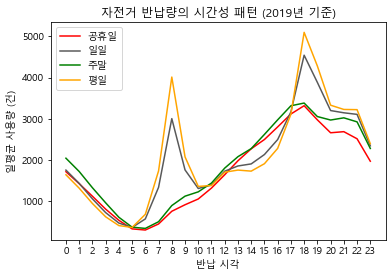

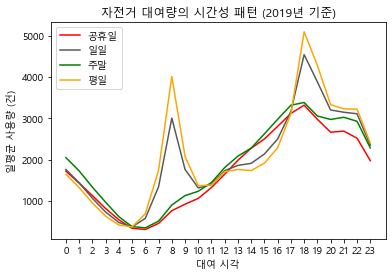

In [44]:
plot_hourly_pattern_bicycle_usage_all_year(hourly_grouped_monthly_df_return_sum, '반납_hour', save_flag)
plot_hourly_pattern_bicycle_usage_all_year(hourly_grouped_monthly_df_return_sum, '대여_hour', save_flag)

### [그래프 해석] 따릉이 일평균 대여/반납량 
•	평일은 출퇴근시간 (07-09시, 17-19시) 사용이 두드러지게 나타나며, 주말과 공휴일은 저녁시간전까지 꾸준히 상승하는 양상을 보임 <br>
•	평일 퇴근시간이 출근시간보다 이용 수가 높은 이유로는 크게 두 가지를 꼽을 수 있음: 1) 퇴근 후 여가 목적의 사용 2) 퇴근시간보다 심리적으로 바쁜 출근시간


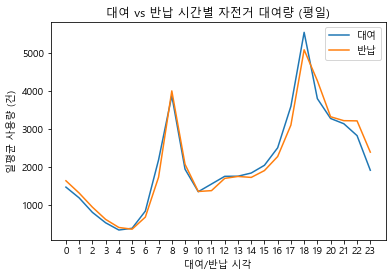

In [45]:
plot_lent_vs_return_hourly_bicycle_usage(hourly_grouped_monthly_df_lent_sum, hourly_grouped_monthly_df_return_sum, '평일', save_flag)

### [그래프 해석] 따릉이 평일 대여량
•	대여와 반납의 시간별 추세가 거의 동일함 <br>
•	다른시간에 비해 출퇴근시간에 대여량과 반납량이 급증함 


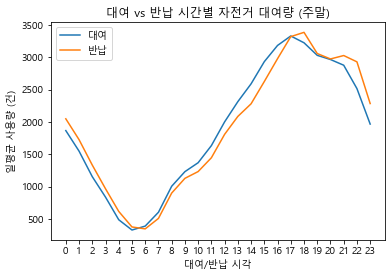

In [46]:
plot_lent_vs_return_hourly_bicycle_usage(hourly_grouped_monthly_df_lent_sum, hourly_grouped_monthly_df_return_sum, '주말', save_flag)

### [그래프 해석] 따릉이 주말 대여량
•	17시 이전에는 대여량이 많고 이후에는 반납량이 많은 추세를 보임 <br>
•	반납과 대여의 시간이 다른 것으로 보아 주말은 평일에 비해 이용시간이 더 긴것으로 볼 수 있음 


### 4d) 시간별 대여 반납 거리 분석

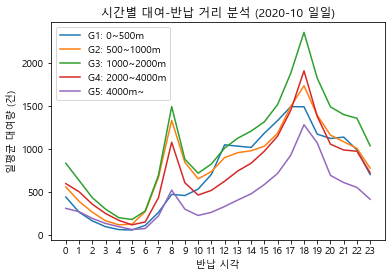

In [47]:
year, month_idx = '2020', 9
tgt_df = dfs_year_group[year][month_idx]
monthly_day_types_cnt = monthly_day_types_cnt_year_group[year][month_idx]
plot_hourly_distance_group(tgt_df, monthly_day_types_cnt, '일일', year, month_idx+1, save_flag=save_flag)

### [그래프 해석] 시간대별 대여-반납 거리 분석
•	1000-2000M 거리를 가장 많이 사용하고, 4000M 이상을 가장 적게 사용하는 것으로 나타남 <br>
•	출퇴근 시간에는 다르시간 대비 중단거리 이용자 수가 증가함 <br>
&nbsp;&nbsp;•	출근시간에는 500-1000M 사용자가, 퇴근시간에는 2000-4000M 사용자가 더 많은 것으로 나타남. 퇴근시간에 더 여유롭고 운동목적이 겸해져서 비교적 긴 거리를 사용하는 것으로 보임 


## 5. 따릉이 지역별 대여량 분석

### 5a) 지역별 대여량 분석 (2021년 6월)
* 2021년 6월 자치구별 대여량 지도 시각화

서울특별시 공공자전거 대여소별 이용정보(월별)  
출처: http://data.seoul.go.kr/dataList/OA-15249/F/1/datasetView.do

In [48]:
june_data_bike_usage = raw_data_for_bike_usage[raw_data_for_bike_usage['대여 일자 / 월'] == 202106.0]
june_data_bike_usage_by_station = june_data_bike_usage.groupby('대여소 그룹').agg({'대여 건수': 'sum'})
june_data_bike_usage_by_station.drop(['정비센터'], inplace = True)
june_data_bike_usage_by_station['자치구'] = june_data_bike_usage_by_station.index
june_data_bike_usage_by_station.head(5)

,대여 건수,자치구
대여소 그룹,,
강남구,99731.0,강남구
강동구,143699.0,강동구
강북구,63684.0,강북구
강서구,361675.0,강서구
관악구,112169.0,관악구


In [49]:
## top10 대여 건수 자치구
top10_station_usage = june_data_bike_usage_by_station.sort_values('대여 건수', ascending=False).head(10)
top10_station_usage.index = np.arange(1, 11)
top10_station_usage['대여 건수'] = top10_station_usage['대여 건수'].astype(int)
top10_station_usage

,대여 건수,자치구
1,361675,강서구
2,294526,송파구
3,260526,영등포구
4,200594,노원구
5,195893,마포구
6,185618,양천구
7,155056,광진구
8,143699,강동구
9,131166,성동구
10,130793,동대문구


In [50]:
state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
bike_usage_by_station_map = folium.Map(location=[37.562225, 126.978555], tiles="OpenStreetMap", zoom_start=11)
folium.Choropleth(
 geo_data=state_geo,
    name='2021년 6월 자치구 별 따릉이 대여량',
    data=june_data_bike_usage_by_station,
    columns=('자치구', '대여 건수'),
    key_on='feature.properties.name',
    fill_color='Greens',
    fill_opacity = 1,
    line_opacity = 1,
    color = 'black',
    legend_name = '대여량'
).add_to(bike_usage_by_station_map)
label_seoul_zones(bike_usage_by_station_map)

In [51]:
if save_flag:
    bike_usage_by_station_map.save('3.2021년-6월-자치구별-대여량.html')
bike_usage_by_station_map

### [지도 해석] 지역별 대여량
•	강서구와 영등포구가 다른 자치구들과 큰 격차로 대여량 1,2위를 차지함 <br>
•	대여소 분포와 비교해보았을 때, 대여량이 더 자치구별로 균등하지 못함<br>
•	서초와 강남은 대여소 대비 대여량이 적은 것으로 나타남 


### 5b) 자주 사용되는 대여소 분석 (2018년 ~ 2020년)

* 연도별 대여량 상위 10개 대여소 (매년 10월 기준)

서울특별시 공공자전거 대여소별 이용정보(월별)
출처: http://data.seoul.go.kr/dataList/OA-15249/F/1/datasetView.do

In [52]:
def freq_used_station(year, topk):
    df = read_csv('../data/서울_공공자전거_대여_월별/공공자전거 이용정보 {}.tsv'.format(year), sep = '\t')
    if '대여소' in df.columns:
        df.rename(columns = {'대여소': '대여소명'}, inplace = True)
    if year == 2017:
        df.rename(columns = {"'대여소'": '대여소명', "'대여소번호'": '대여소번호', "'이용건수'": '이용건수'}, inplace = True)   
    df = df[['대여소번호', '대여소명', '이용건수']]
    df = df.groupby('대여소번호').agg({'대여소명': 'first', '이용건수': 'sum'})
    df = df.sort_values(by = '이용건수', ascending = False).head(topk)
    df.index = np.arange(1, len(df) + 1)
    return df

def plot_freq_used_station(year, df, topk, save_flag=save_flag):
    fig = plt.figure(figsize = (10, 6), facecolor='white')
    ax = fig.add_subplot(111)

    table = plt.table(cellText = df.values,
             rowLabels = df.index,
             colLabels = df.columns,
             loc = 'center',
             colWidths = [1, .2])
    table.auto_set_font_size(False)
    table.set_fontsize(20)
    table.scale(1,2.2)

    name = "{}년 상위 {}개 대여소".format(year, topk)
    ax.set_title(name, fontsize = 20)
    ax.axis('off')
    filename = "3.{}.png".format(name)
    if save_flag:
        plt.savefig(filename)
    plt.show()

../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2018.tsv 파일을 로딩합니다.
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2019.tsv 파일을 로딩합니다.
../data/서울_공공자전거_대여_월별/공공자전거 이용정보 2020.tsv 파일을 로딩합니다.


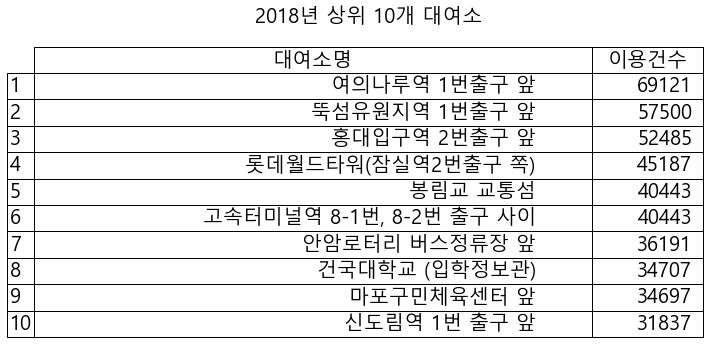

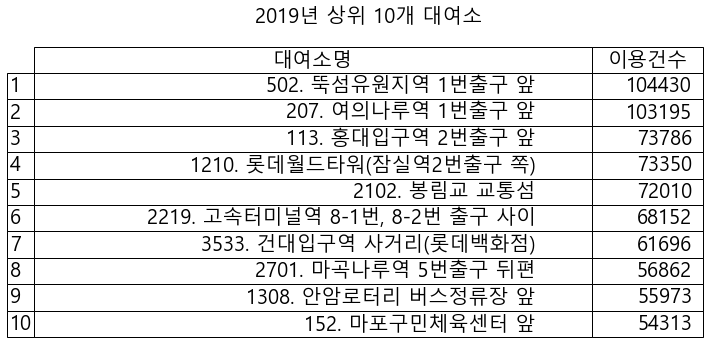

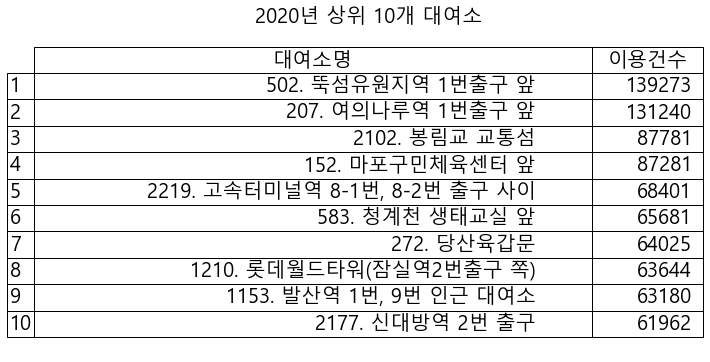

In [53]:
topk = 10
freq_used_2018_df = freq_used_station(2018, topk)
freq_used_2019_df = freq_used_station(2019, topk)
freq_used_2020_df = freq_used_station(2020, topk)
plot_freq_used_station(2018, freq_used_2018_df, topk, save_flag)
plot_freq_used_station(2019, freq_used_2019_df, topk, save_flag)
plot_freq_used_station(2020, freq_used_2020_df, topk, save_flag)

### [표 해석] 상위 10개 대여소
•	대여량 기준으로 Top 10 대여소를 뽑아봤을 때, 많은 사람들이 공통적으로 자주 이용하는 “한강이나 공원” 근처 대여소가 순위권에 많이 들었음 <br>
•	시간이 지남에 따라 주택가나 변화가 근처의 대여소도 순위에 이름을 올리고 있음 <br>
•	2020년도는 코로나로 인한 야외활동을 지향하는 시민들이 인식이 반영되어, 랭킹에 이동수단보다 여가수단과 관련된 대여소가 훨씬 많은 수가 이름을 올림<br>
•	단순히 대여소 대여량의 랭킹만으로 이용목적을 완벽히 파악하는데는 한계가 있지만, 따릉이의 이용목적이 시간이 지날수록 다양해지고 있다는 추론이 가능함


## 6. 계절별 대여량 분석

### 6a) 계절별 일평균 대여량 (2019년)

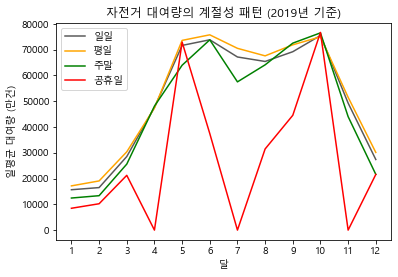

In [54]:
plot_monthly_pattern_bicycle_usage(monthly_mean_df[monthly_mean_df['year'] == 2019], save_flag=save_flag)

### [그래프 해석] 계절별 일평균 대여량
•	날씨가 좋은 봄과, 가을이 가장 높은 수치를 기록하였으며, 그 중에서도 가을에 대여량이 가장 높음 <br>
•	덥고 장마철이 포함된 여름과, 추운 겨울은 비교적 대여량이 적음 <br>
•	공휴일이 많은 5월과 10월은, 공휴일 사용자 수가 최대치를 기록함 (평일, 주말과 비슷한 수준임) 


## 7. 서울시 자전거 도로 현황 분석

### 7a) 서울시 자전거 도로 현황

* 서울시 자치구별 자전거 도로 길이 분석

사용한 데이터: 서울시 자전거도로 현황 통계  
출처: http://data.seoul.go.kr/dataList/276/S/2/datasetView.do

In [55]:
bike_road_raw.head(10)

,기간,자치구,자치구(2),합계,합계.1,자전거전용도로,자전거전용도로.1,자전거보행자겸용도로,자전거보행자겸용도로.1,자전거전용차로,자전거전용차로.1,자전거우선도로,자전거우선도로.1
0,기간,자치구,자치구(2),구간,길이,구간,길이,구간,길이,구간,길이,구간,길이
1,2020,합계,합계,"1,151","1,258.8",199,182.7,687,810.4,95,74.3,170,191.5
2,2020,도로변,소계,"1,087",978.5,184,138.5,638,574.3,95,74.3,170,191.5
3,2020,도로변,종로구,38,26.5,-,-,9,9.5,13,6.9,16,10.2
4,2020,도로변,중구,18,15.3,-,-,4,4.6,-,-,14,10.7
5,2020,도로변,용산구,26,33,5,2,11,10.6,-,-,10,20.4
6,2020,도로변,성동구,31,27.2,1,0.3,18,16.9,3,2,9,8
7,2020,도로변,광진구,50,46.8,1,0.2,43,41.7,1,0.3,5,4.6
8,2020,도로변,동대문구,30,37.8,4,1.4,12,7.6,-,-,14,28.8
9,2020,도로변,중랑구,16,10,7,3.5,9,6.5,-,-,-,-


In [56]:
bike_road = bike_road_raw[['자치구(2)', '합계', '합계.1']].copy()
bike_road.drop([0,1,2,28,29,30,31], inplace = True)
bike_road.rename(columns={"자치구(2)": "자치구", "합계": "구간", "합계.1": "길이"}, inplace = True)
bike_road = bike_road.sort_values(by = '자치구').reset_index(drop=True)
bike_road['구간'] = bike_road['구간'].astype(float)
bike_road['길이'] = bike_road['길이'].astype(float)
bike_road.head(10)

,자치구,구간,길이
0,강남구,65.0,90.0
1,강동구,66.0,72.0
2,강북구,8.0,8.7
3,강서구,80.0,76.4
4,관악구,19.0,29.5
5,광진구,50.0,46.8
6,구로구,38.0,26.5
7,금천구,19.0,8.9
8,노원구,40.0,42.9
9,도봉구,8.0,12.9


### [그래프 해석] 자전거 도로 현황
•	현재 송파구, 강남구, 강서구, 강동구에 자전거 도로가 가장 많이 설치되어 있음 

### 결론
## 1. 따릉이 지도 및 길찾기 서비스

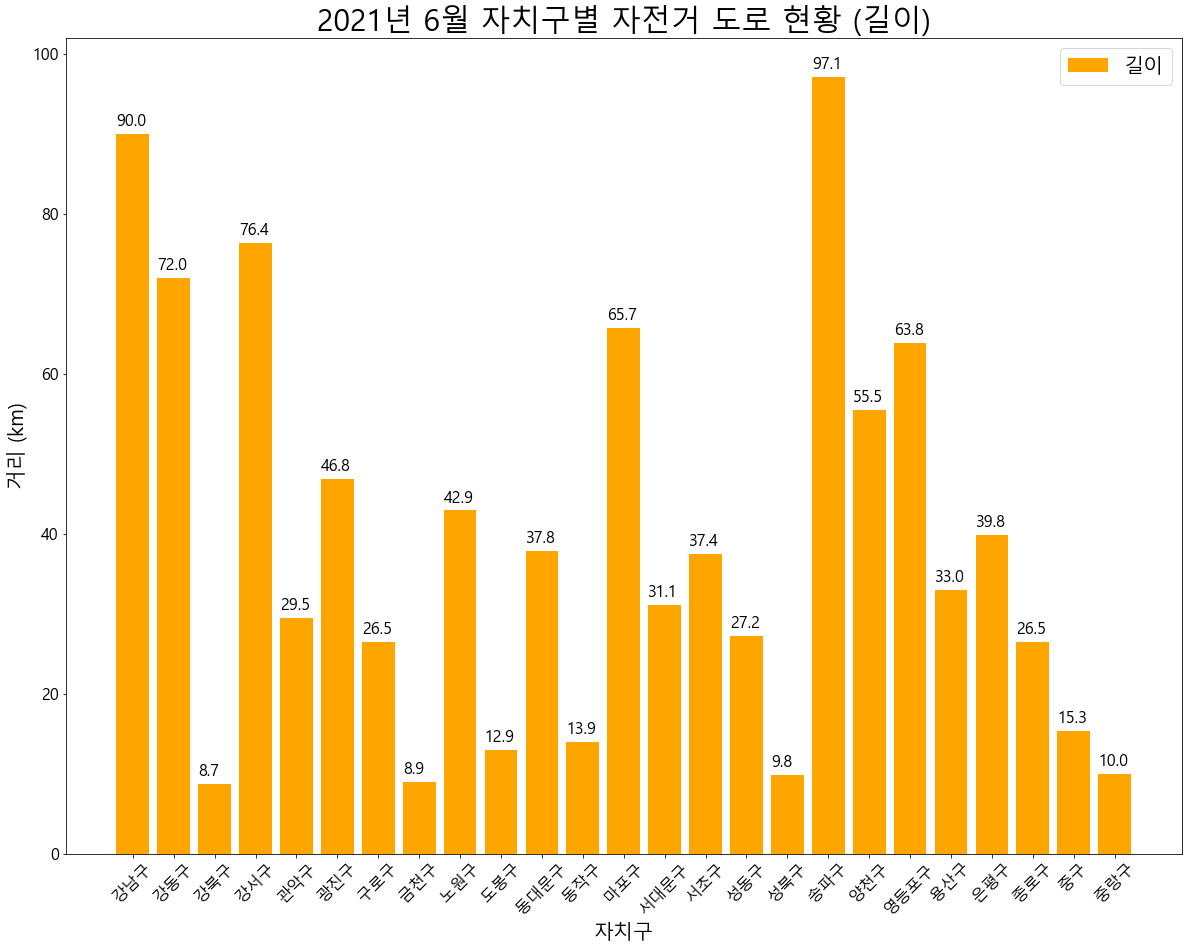

In [57]:
plt.figure(figsize=(20, 15))
plt.bar(bike_road['자치구'], bike_road['길이'], color = 'orange')
plt.xlabel('자치구', fontsize = 20)
plt.ylabel('거리 (km)', fontsize = 20)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)

for idx, data in enumerate(bike_road['길이']):
    plt.text(x=idx-0.4 , y=data+1, s=str(data), fontsize=16)

plt.legend(['길이'], fontsize = 20)
plt.title('2021년 6월 자치구별 자전거 도로 현황 (길이)', fontsize = 30)
if save_flag:
    plt.savefig('2.2021년-6월-자치구별-자전거-도로-현황-길이.png', transparent = True)
plt.show()


<img src="1.png">

### 1.1 따릉이 지도
버스정류장만 보이던 기존의 지도에 따릉이 대여소와 잔여 자전거 수를 함께 보여주어 시민들이 더욱 쉽게 이용가능한 따릉이 대여소를 찾도록 도와줌 

### 1.2 따릉이 길찾기 서비스
버스와 지하철만 고려하여 최적의 이동동선을 보여주던 길찾기 서비스에 따릉이도 포함하여 최적동선을 보여주는 서비스를 제안함. 이를 통해 따릉이를 다른 대중교통처럼 사용할 수 있다는 인식을 개선하고자 함 

## 2. 원활한 서비스 제공을 위한 정책 제안


<img src = "2.png">

•	위 서비스를 더 원활하게 제공하기 위해서는 시민들의 따릉이 대여와 사용을 더욱 편리하게 만들어 주어야 함 <br>
1) 원활한 따릉이 대여 : 따릉이 대여소의 빈익부 부익부 현상을 해결하여, 따릉이가 없어서 타지 못하는 현상을 해소해야함 <br>

2) 자전거도로 설치: 서울시 자전거 도로 비율이 11%로 다른 지역에 비해 낮은 수치를 기록함. 더욱 원활하고 쾌적한 자전거 사용을 위해 더 많은 자전거 도로를 설치해야함. “영등포구, 노원구, 구로구” 와 같은 사용량이 많은데 자전거도로고 적은 자치구에 우선적으로 설치하는 것을 제안함


## 3. 기대 효과


![기대효과](1.png)

기대효과는 크게 교통, 건강, 환경관련으로 나누어 볼 수 있음. <br>
1) 교통관련<br>
&nbsp;&nbsp;•	따릉이 인식 확립 - 집 앞 마트 및 음식점을 갈 때 사용하는 “단거리 이동수단”과 “대중교통”의 일환으로 이미지 확립<br>
&nbsp;&nbsp;•	대중교통과의 연계 - 길찾기에 따릉이를 포함한 최적 경로를 제공함으로써 다른 대중교통과의 편리한 연계를 기대함<br>
&nbsp;&nbsp;•	출퇴근시간 교통혼잡도 해소 - 출퇴근 인구 분산 효과를 기대함 <br>
&nbsp;&nbsp;•	시민 교통 만족도 상승 - 전반적인 교통부분에서 만족도가 상승할 것으로 기대함 <br>
2) 건강관련<br>
&nbsp;&nbsp;•	코로나 감염 우려 해소 – 대중교통 밀집도 감소로 인한 안전한 대중교통으로 인식 제고와, 이로 인한 코로나 감염 우려 해소 <br>
&nbsp;&nbsp;•	자전거 사용증가로 인한 건강 증진 <br>
3) 환경관련 <br>
&nbsp;&nbsp;•	탄소배출 절감 효과


## 한계점 
서울특별시 공공자전거 대여이력 데이터 누락:  <br>
&nbsp;&nbsp;•   월별 이용정보 데이터와 비교했을때 대여이력 2020년 5월-9월 데이터에서 부분 누락이 발견 되었습니다. (9월의 경우 150만건 차이) <br>
&nbsp;&nbsp;•	특정 월이 아닌 “년단위”의 데이터는 2019년 데이터를 사용하였습니다. <br>
&nbsp;&nbsp;•	2020년의 경우 코로나가 시작된 년도였기에 코로나 이전과 이후와 같은 비교를 넣지 못한 점이 아쉽습니다. <br>
&nbsp;&nbsp;•	계절별 일평균 대여량과 같이 특정 년도가 아닌 전반적은 트렌드가 필요한 데이터의 경우 2020년 데이터가 누락되지 않았다면 2019~현재까지 트렌드를 볼 수 있었을 거 같아 아쉬웠습니다. <br>
데이터의 품질 자체가 분석하는데 영향을 많이 준다는 사실을 느꼈습니다. 데이터의 결측치가 많은 경우, 특정 기간으로 데이터 분석의 범위를 좁히면서 원본 데이터에서 뽑아낼 수 있는 정보 및 분석이 소실되었을 가능성이 있어 보입니다. 


## 마치며
2020년 코로나 19가 우리의 일상을 뒤흔들지 벌써 1년 반이 흘렸습니다. 코로나 19가 없는 세상으로 돌아가기까지는 많은 시간이 걸릴 것으로 보이며, 어쩌면 다시는 돌아가지 못할 수 도 있습니다.  <br>
코로나 19의 선한 영향 중 하나로 “따릉이”라는 이동수단이 각광받기 시작하였고, 저희는 시민들의 더욱 편리하고 만족스러운 교통 사용을 위해 따릉이를 더욱 활성화하는 방안을 모색하였습니다. 따릉이 길찾기 서비스 및 지도를 통해 더 많은 사람들이 따릉이를 사용하게 되기를 바랍니다. 한 명 한 명의 따릉이 사용이 개인의 건강 뿐 아니라 교통과 환경에까지 긍정적인 영향을 미칠 수 있으리라 기대하며 글을 마칩니다. 



<br><br><br>

아이콘 출처: <br>
Icons made by Freepik(https://www.freepik.com) from Flaticon(https://www.flaticon.com)

'본 저작물의 저작권은 Apache License v2.0을 따릅니다'